<a href="https://colab.research.google.com/github/thanhtruchhh/Churn_Prediction/blob/main/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import librabries and load data

In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
url = '/content/drive/MyDrive/Dataset/DACK16/ChurnPrediction/churn_prediction.xlsx'

In [ ]:
df = pd.read_excel(url)

# Explore data

In [ ]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [ ]:
df.shape

(5630, 20)

In [ ]:
df.info()

In [ ]:
df.duplicated().any()

False

In [ ]:
df['CustomerID'].is_unique

True

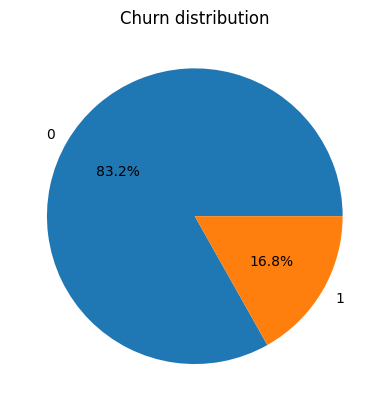

In [ ]:
users_by_churn = df['Churn'].value_counts().reset_index().rename(columns = {'index': 'churn', 'Churn' : 'cnt_users'})
plt.pie(users_by_churn['cnt_users'], labels = users_by_churn['churn'], autopct='%1.1f%%')
plt.title('Churn distribution')
plt.show()

In [ ]:
cnt_null = df.isnull().sum()
pct_null = round(df.isnull().sum() * 100 / df.shape[0], 2)
pd.DataFrame({'#null values' : cnt_null,
             '%null values' : pct_null}).sort_values(by ='#null values', ascending = False)

,#null values,%null values
DaySinceLastOrder,307,5.45
OrderAmountHikeFromlastYear,265,4.71
Tenure,264,4.69
OrderCount,258,4.58
CouponUsed,256,4.55
HourSpendOnApp,255,4.53
WarehouseToHome,251,4.46
CustomerID,0,0.00
MaritalStatus,0,0.00
Complain,0,0.00


In [ ]:
print(f'Total number of missing values in the dataset: {df.isna().sum().sum()}')
cnt_missing_rows = df.isna().any(axis = 1).sum()
print(f'Number of rows containing >= 1 missing value: {cnt_missing_rows}')
print(f'Percentage of rows containing >= 1 missing value: {round(cnt_missing_rows * 100 /df.shape[0], 2)}%')

Total number of missing values in the dataset: 1856
Number of rows containing >= 1 missing value: 1856
Percentage of rows containing >= 1 missing value: 32.97%


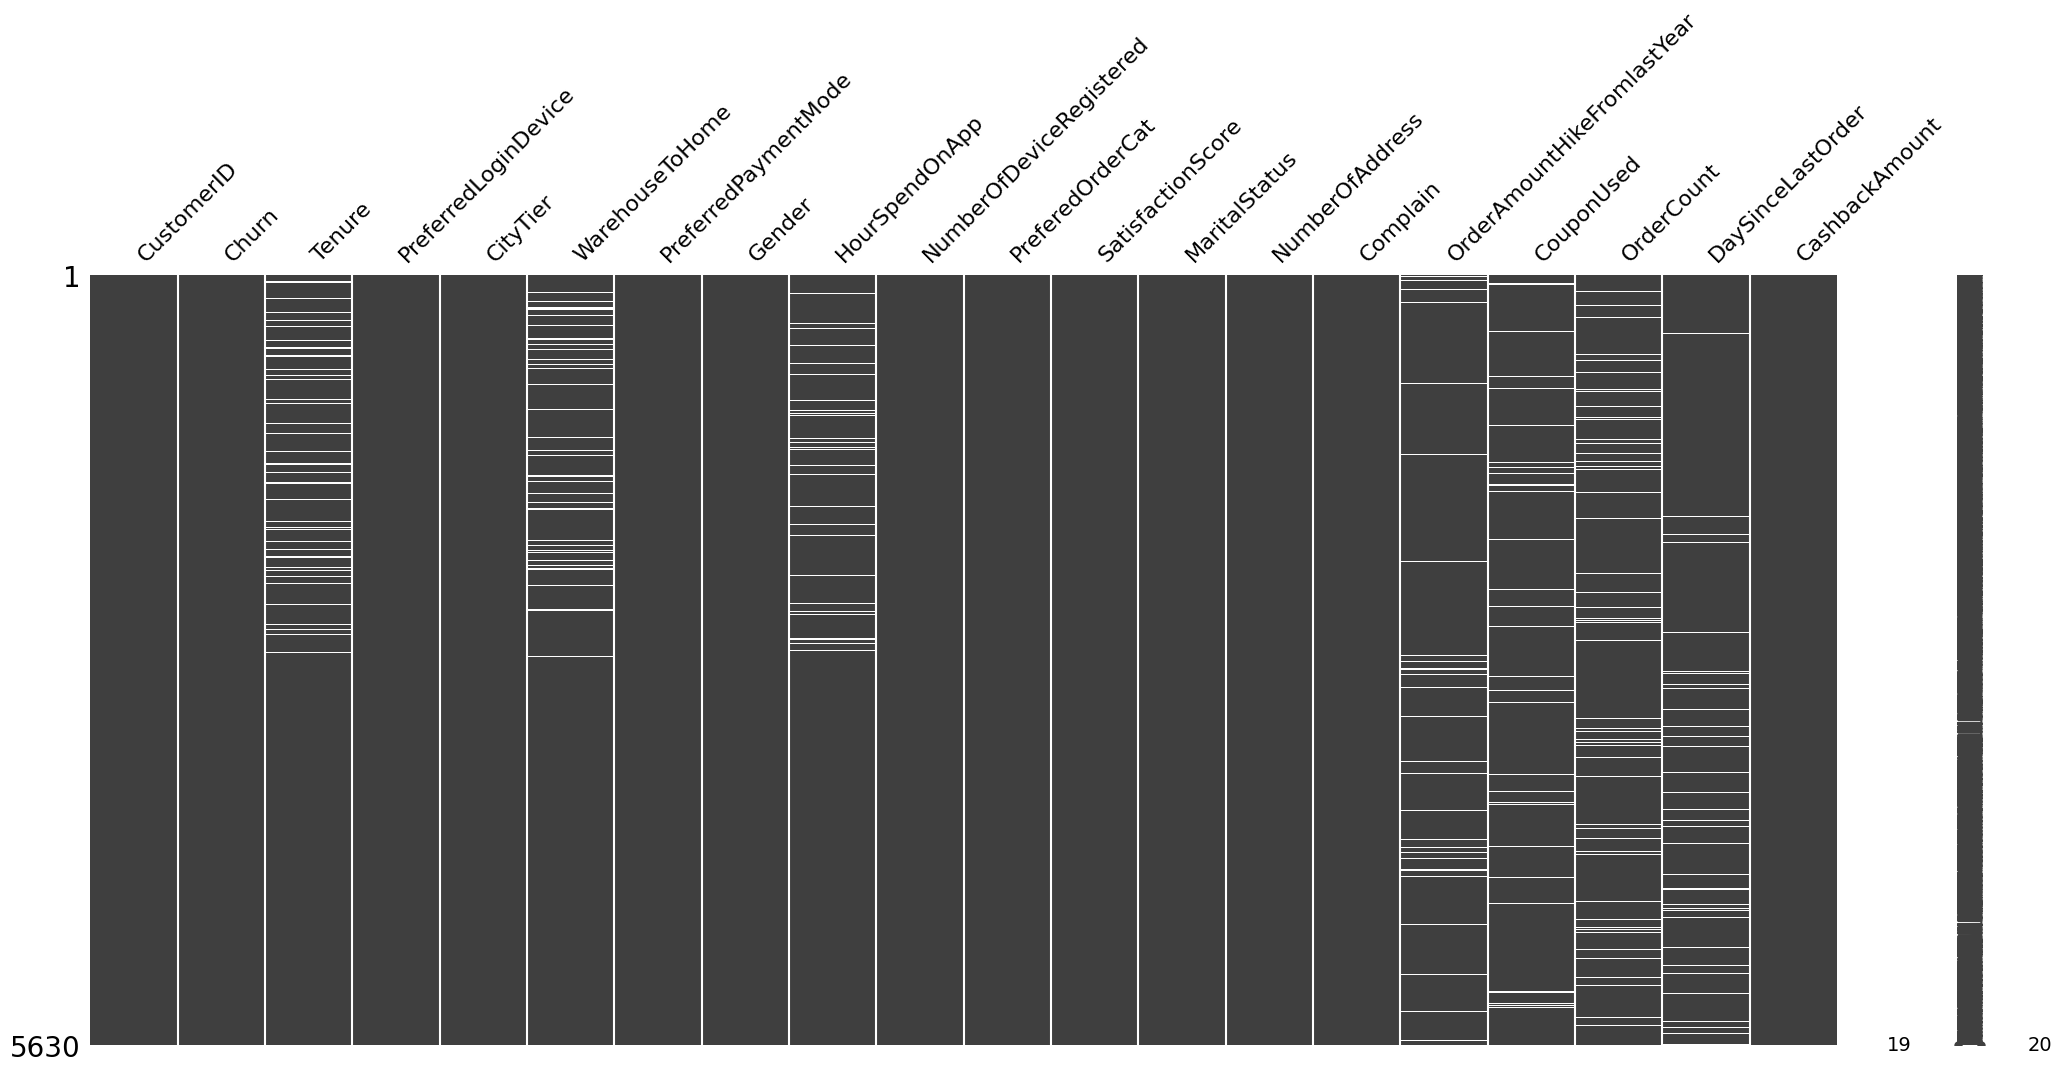

In [ ]:
# Visualize missingness matrix
msno.matrix(df)
plt.show()

In [ ]:
number_columns = df.select_dtypes(include = 'number').drop(['CustomerID', 'Churn'], axis = 1).columns

In [ ]:
df[number_columns].describe(include = 'number').transpose()

,count,mean,std,min,25%,50%,75%,max
Tenure,5366.0,10.189899,8.557241,0.0,2.00,9.00,16.0000,61.00
CityTier,5630.0,1.654707,0.915389,1.0,1.00,1.00,3.0000,3.00
WarehouseToHome,5379.0,15.639896,8.531475,5.0,9.00,14.00,20.0000,127.00
HourSpendOnApp,5375.0,2.931535,0.721926,0.0,2.00,3.00,3.0000,5.00
NumberOfDeviceRegistered,5630.0,3.688988,1.023999,1.0,3.00,4.00,4.0000,6.00
SatisfactionScore,5630.0,3.066785,1.380194,1.0,2.00,3.00,4.0000,5.00
NumberOfAddress,5630.0,4.214032,2.583586,1.0,2.00,3.00,6.0000,22.00
Complain,5630.0,0.284902,0.451408,0.0,0.00,0.00,1.0000,1.00
OrderAmountHikeFromlastYear,5365.0,15.707922,3.675485,11.0,13.00,15.00,18.0000,26.00
CouponUsed,5374.0,1.751023,1.894621,0.0,1.00,1.00,2.0000,16.00


In [ ]:
# Display distribution of values in int columns
int_columns = df.select_dtypes(include = 'int').drop(['CustomerID', 'Churn'], axis = 1).columns
for col in int_columns:
  cnt = df[col].value_counts()
  print(f'Distribution of {col} \n{cnt}\n_________________________________\n')

Distribution of CityTier 
1    3666
3    1722
2     242
Name: CityTier, dtype: int64
_________________________________

Distribution of NumberOfDeviceRegistered 
4    2377
3    1699
5     881
2     276
1     235
6     162
Name: NumberOfDeviceRegistered, dtype: int64
_________________________________

Distribution of SatisfactionScore 
3    1698
1    1164
5    1108
4    1074
2     586
Name: SatisfactionScore, dtype: int64
_________________________________

Distribution of NumberOfAddress 
2     1369
3     1278
4      588
5      571
6      382
1      371
8      280
7      256
9      239
10     194
11      98
19       1
21       1
20       1
22       1
Name: NumberOfAddress, dtype: int64
_________________________________

Distribution of Complain 
0    4026
1    1604
Name: Complain, dtype: int64
_________________________________



In [ ]:
# Display distribution of values in float columns
for col in df.select_dtypes(include = 'float').columns.to_list():
  print(f'{col}: {len(df[col].dropna().unique())}')

Tenure: 36
WarehouseToHome: 34
HourSpendOnApp: 6
OrderAmountHikeFromlastYear: 16
CouponUsed: 17
OrderCount: 16
DaySinceLastOrder: 22
CashbackAmount: 2586


In [ ]:
hours = df['HourSpendOnApp'].dropna().unique()
hours.sort()
print(hours)

[0. 1. 2. 3. 4. 5.]


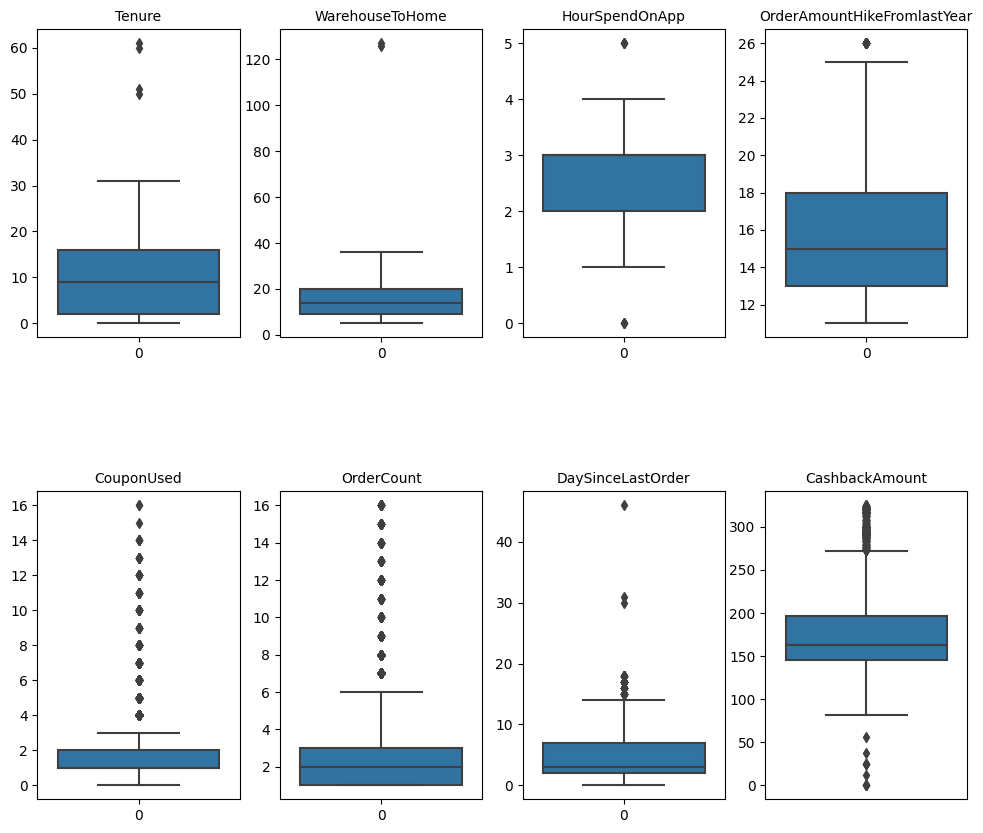

In [ ]:
float_columns = df.select_dtypes(include = 'float').columns.to_list()
# # Set number of columns, rows
# no_cols = 4
# no_rows = math.ceil(len(cont_columns) / no_cols)

# # Create a figure and axis for the subplots
# fig, axs = plt.subplots(no_rows, no_cols, figsize=(12, 5 * no_rows))
fig, axs = plt.subplots(2, 4, figsize=(12, 10))
fig.subplots_adjust(hspace=0.5)

# Loop through the columns and create distribution plots
for i, col in enumerate(float_columns):
    row_idx = i // 4
    col_idx = i % 4
    ax = axs[row_idx, col_idx]

    sns.boxplot(df[col], ax=ax)
    ax.set_title(col, fontsize = 10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.xticks([])

# # Remove any empty subplots
# if len(cont_columns) % no_cols != 0:
#     for i in range(len(cont_columns) % no_cols, no_cols):
#         fig.delaxes(axs[no_rows - 1, i])

plt.show()

In [ ]:
# Check if float columns contain only int values
# Drop null to ensure working with valid numeric data
df['OrderCount'].dropna().apply(lambda x: x.is_integer()).all()

True

In [ ]:
df['CouponUsed'].dropna().apply(lambda x: x.is_integer()).all()

True

In [ ]:
# Display distribution of values in object columns
object_columns = df.select_dtypes(include = 'object').columns

for col in object_columns:
  cnt = df[col].value_counts()
  print(f'Distribution of {col} \n{cnt}\n_________________________________\n')

Distribution of PreferredLoginDevice 
Mobile Phone    2765
Computer        1634
Phone           1231
Name: PreferredLoginDevice, dtype: int64
_________________________________

Distribution of PreferredPaymentMode 
Debit Card          2314
Credit Card         1501
E wallet             614
UPI                  414
COD                  365
CC                   273
Cash on Delivery     149
Name: PreferredPaymentMode, dtype: int64
_________________________________

Distribution of Gender 
Male      3384
Female    2246
Name: Gender, dtype: int64
_________________________________

Distribution of PreferedOrderCat 
Laptop & Accessory    2050
Mobile Phone          1271
Fashion                826
Mobile                 809
Grocery                410
Others                 264
Name: PreferedOrderCat, dtype: int64
_________________________________

Distribution of MaritalStatus 
Married     2986
Single      1796
Divorced     848
Name: MaritalStatus, dtype: int64
_________________________________


- About 80% users do not churn &rarr; Data is not much imbalanced &rarr; Accept.
- Dataset has 5630 rows, 20 columns.
- There are no duplicate. All values in CustomerID column are unique.
- 6 out of 7 columns contain < 5% missing values. Howerver each observation only contains at most 1 null value &rarr; 32.97% of dataset contains missing values.
- Some values in 1 column are similar:
  - **PreferredLoginDevice**: Mobile Phone vs. Phone
  - **PreferredPaymentMode**: Credit Card vs. CC, COD vs. Cash on Delivery
  - **PreferedOrderCat**: Mobile Phone vs. Mobile
- Some numeric categorical data:
  - **CityTier**: Categorizes customers into different city tiers *(1, 2, 3)*.
  - **SatisfactionScore**: Categorizes customers into different satisfaction levels *(1 -> 5)*.
  - **Complain**: It is a binary categorical variable with 2 discrete values *(0, 1)*.
  - **HourSpendOnApp**: Number of hours spend on mobile application or website *(0 -> 5)*
- **NumberOfAddress**: Contains a few very large values *(19, 21, 22, 23)* but it could be normal because a customer specified different delivery addresses for different orders.
- Columns with float values exhibit outliers and don't follow a normal distribution.
- Although **OrderCount** and **CouponUsed** are float columns, they only contain whole numbers

# Proccess data

## Clean data

CustomerID typically doesn't contain any predictive information so we'll remove it.

In [2]:
df.drop(['CustomerID'], axis = 1, inplace = True)

NameError: ignored

Merge 2 same values:
- Phone and mobile phone
- CC and credit card
- COD and cash on delivery
- Mobile phone and mobile

In [ ]:
df.replace({'PreferredLoginDevice' : 'Phone', 'PreferredPaymentMode' : ['CC', 'COD'], 'PreferedOrderCat' : 'Mobile Phone'},
           {'PreferredLoginDevice' : 'Mobile Phone', 'PreferredPaymentMode' : ['Credit Card', 'Cash on Delivery'], 'PreferedOrderCat' : 'Mobile'},
           inplace = True)

In [ ]:
print(f"{df['PreferredLoginDevice'].unique()}\n{df['PreferredPaymentMode'].unique()}\n{df['PreferedOrderCat'].unique()}")

['Mobile Phone' 'Computer']
['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']
['Laptop & Accessory' 'Mobile' 'Others' 'Fashion' 'Grocery']


- There are 32.97% of rows with null value. If we drop all of them, it'll cause a data lost.
- Columns with missing values have non normal distribution and ouliers. Therefore, we'll replace null values by median of the variable.

In [ ]:
# Get columns with missing data
columns_with_null = df.columns[df.isna().any()]

for col in columns_with_null:
  median = df[col].median()
  df[col].fillna(value = median, inplace = True)

In [ ]:
df.isna().any().sum()

0

## Select features

### EDA

<ipython-input-27-6ca65f9b728c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sns.heatmap(df.corr(), annot=True, annot_kws={"fontsize": 8}, cmap='YlOrBr', fmt=".2f")


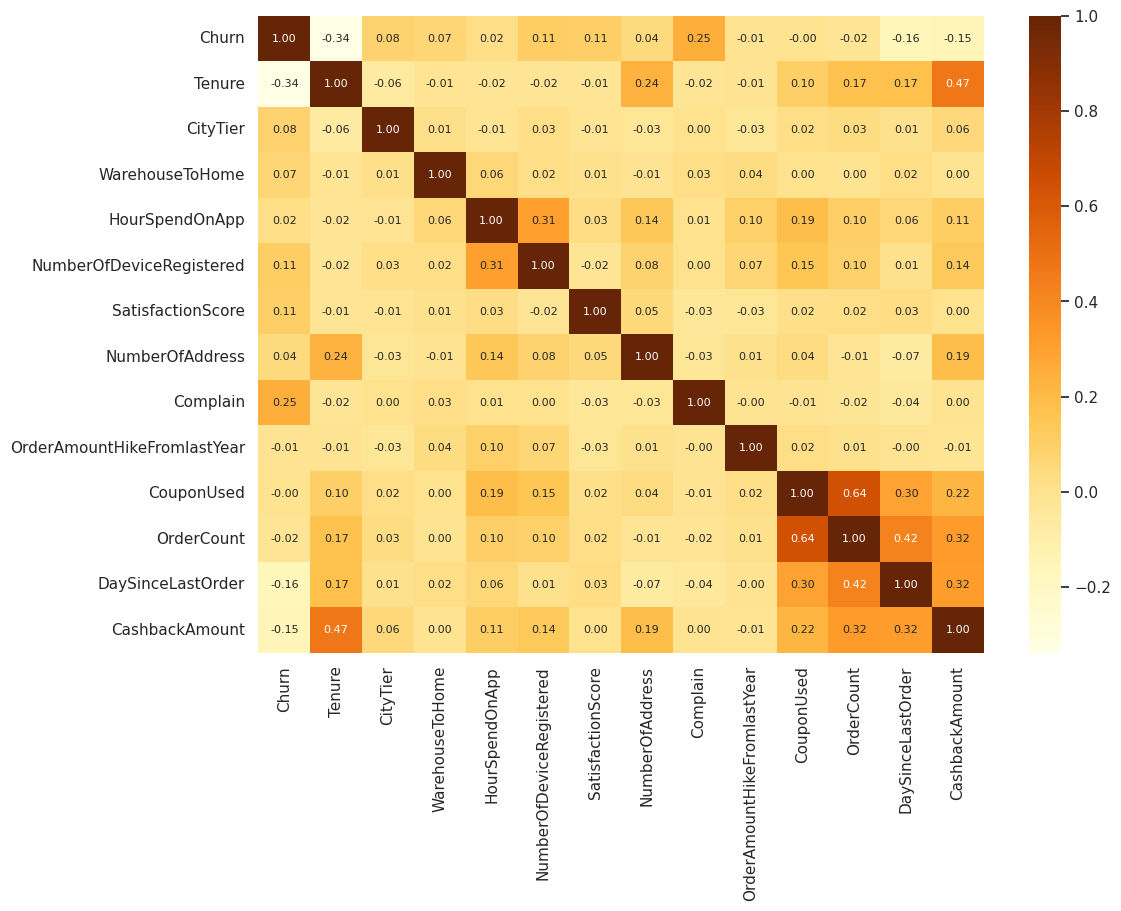

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
dataplot = sns.heatmap(df.corr(), annot=True, annot_kws={"fontsize": 8}, cmap='YlOrBr', fmt=".2f")

**Tenure** has a moderate negative relationship with Churn *(Correlation coefficient = -0.34)*. -> Users who have been with the company for a longer period of time are less likely to leave compared to those with shorter tenures.

In [ ]:
features = ['Tenure']

In [ ]:
# Create a function to calc percentage of churned users by all values in 1 feature
# Return a new df

def percentage(df, target, feature):
  # Create 2 df of churn and not churn
  churn = df[df[target] == 1][feature].value_counts().reset_index()
  churn.columns = [feature, '#churn']

  not_churn = df[df[target] == 0][feature].value_counts().reset_index()
  not_churn.columns = [feature, '#not churn']

  # Merge 2 df
  cat_df = churn.merge(not_churn,
                      how = 'outer',
                      right_on = feature,
                      left_on = feature)

  # If categoris don't have occurrences in 1 of 2 groups, the corresponding count = null -> Fill with 0
  cat_df.fillna(0, inplace = True)

  # Calc %churn users
  cat_df['%churn'] = cat_df['#churn']  / (cat_df['#not churn'] + cat_df['#churn'])
  # return cat_df[[col, '%churn']]
  return cat_df

In [ ]:
cat_columns = df.select_dtypes(include = 'object').columns.to_list() + ['Complain', 'CityTier', 'SatisfactionScore', 'HourSpendOnApp']

for col in cat_columns:
  cat_df = percentage(df, 'Churn', col)
  print(f'Churn ratio by {col}\n{cat_df.sort_values(by = "%churn", ascending = False)}\n_________________________________\n')

Churn ratio by PreferredLoginDevice
  PreferredLoginDevice  #churn  #not churn    %churn
1             Computer     324        1310  0.198286
0         Mobile Phone     624        3372  0.156156
_________________________________

Churn ratio by PreferredPaymentMode
  PreferredPaymentMode  #churn  #not churn    %churn
3     Cash on Delivery     128         386  0.249027
2             E wallet     140         474  0.228013
4                  UPI      72         342  0.173913
0           Debit Card     356        1958  0.153846
1          Credit Card     252        1522  0.142052
_________________________________

Churn ratio by Gender
   Gender  #churn  #not churn    %churn
0    Male     600        2784  0.177305
1  Female     348        1898  0.154942
_________________________________

Churn ratio by PreferedOrderCat
     PreferedOrderCat  #churn  #not churn    %churn
0              Mobile     570        1510  0.274038
2             Fashion     128         698  0.154964
1  Laptop & Acce

- **PreferredLoginDevice**: Users who prefer to use a computer have a higher churn rate *(19.83%)* compared to those who regularly use a mobile phone *(15.62%)*.
- **PreferredPaymentMode**: Users who tend to choose **COD** have a high churn rate *(24.9%)*. On the other hand, those using a credit card have the lowest churn rate *(14.2%)*.
- **Gender**: There is no significant difference in churn rates between males *(17.73%)* and females*(15.49%)*.
- **PreferredOrderCategory**: Customers who prefer mobile products have the highest churn rate *(27.4%)*, while those choosing others and grocery have the lowest churn rates *(7.58% and 4.88%)*.
- **MaritalStatus**: Users who are single have the highest churn rate *(26.73%)*. In contrast, those who are married have the lowest churn rate *(11.52%)*.
- **Complain**: Users who have raised any complaints in the last month have a higher churn rate *(31.67%)* compared to those who have not complained *(10.93%)*.
- **CityTier**: Users in city tier 3 have the highest churn rate *(21.37%)*, followed by city tier 2 *(19.83%)*, and tier 1 *(14.51%)*. This suggests that the smaller and less economically developed (higher city tier), the higher churn rate.
- **SatisfactionScore**: Users with a satisfaction score of 5 have the highest churn rate *(23.83%)*, while users with a score of 1 have the lowest churn rate *(11.51%)*. This suggests that a higher satisfaction score is associated with a higher churn rate -> 1 represents satisfaction and 5 represents dissatisfaction.
- **HourSpendOnApp**:
  - There is no significant difference in churn rates among users who spend 2 hours *(15.77%)*, 3 hours *(17.61%)*, and 4 hours *(16.84%)* on app.
  - Users who spend 1, 5 hours or no time on app are not churn. However, the sample size of these groups is very small and potentially not representative of the overall user population.

Except Gender and HourSpendOnApp, all above features potentially influence churn.

In [ ]:
# Remove gender, hourspendonapp from the features list
cat_columns.remove('Gender')
cat_columns.remove('HourSpendOnApp')

In [ ]:
features = features + cat_columns

Distance from warehouse to home:

* WarehouseToHome <= P25: Near
* WarehouseToHome <= P75: Moderate
* WarehouseToHome > P75: Far

In [ ]:
# Calculate percentiles of distance in between warehouse to home of customer
distance_p25 = df['WarehouseToHome'].quantile(0.25)
distance_p75 = df['WarehouseToHome'].quantile(0.75)

# Create bins edges and lables for distance from warehouse to home
distance_edges = [0, distance_p25, distance_p75, float('inf')]
distance_labels = ['Near', 'Moderate', 'Far']

# Create distance column
df['Distance'] = pd.cut(df['WarehouseToHome'], bins = distance_edges, labels = distance_labels)

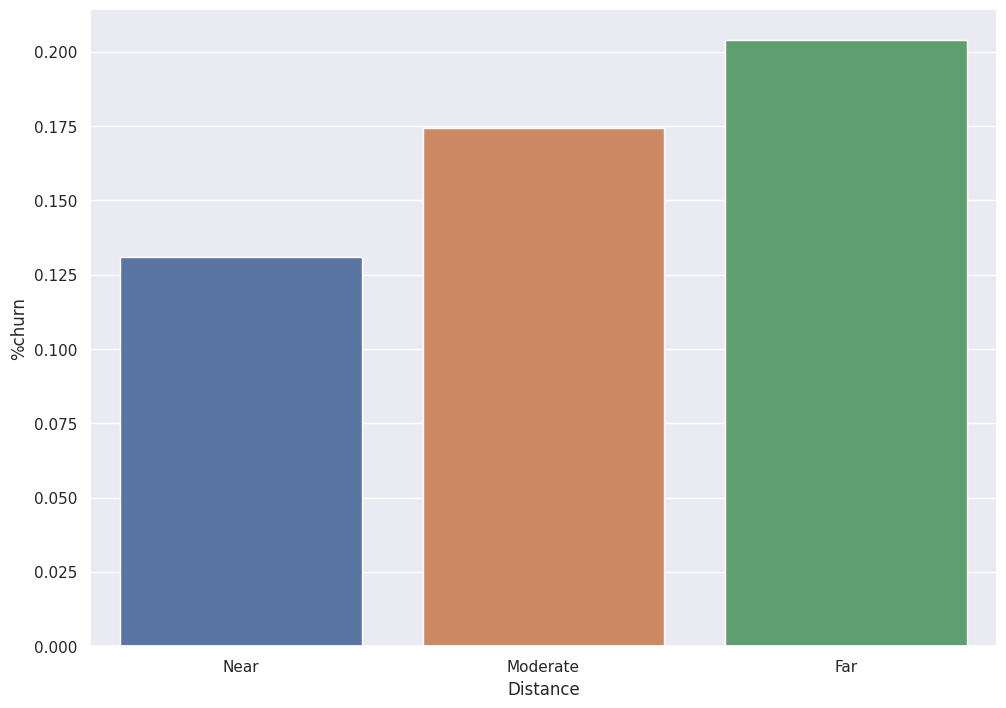

In [ ]:
distance_df = percentage(df, 'Churn', 'Distance').sort_values(by = '%churn', ascending = False)
sns.barplot(data = distance_df, x = 'Distance', y = '%churn')
plt.show()

 **Distance**: Users who live near warehouse have the lowest churn rate *(13.1%)*, followed by those at a moderate *(17.44%)*, and **far** distance *(20.4%)* -> The father distance from warehouse to home, the higher churn rate, possibly due to delivery times.

In [ ]:
features.append('Distance')

In [ ]:
print('After EDA, we keep below columns as features of model:')
for feature in features:
  print(f'- {feature}')

After EDA, we keep below columns as features of model:
- Tenure
- PreferredLoginDevice
- PreferredPaymentMode
- PreferedOrderCat
- MaritalStatus
- Complain
- CityTier
- SatisfactionScore
- Distance


In [ ]:
data = df[features + ['Churn']]
data.head()

,Tenure,PreferredLoginDevice,PreferredPaymentMode,PreferedOrderCat,MaritalStatus,Complain,CityTier,SatisfactionScore,Distance,Churn
0,4.0,Mobile Phone,Debit Card,Laptop & Accessory,Single,1,3,2,Near,1
1,9.0,Mobile Phone,UPI,Mobile,Single,1,1,3,Near,1
2,9.0,Mobile Phone,Debit Card,Mobile,Single,1,1,3,Far,1
3,0.0,Mobile Phone,Debit Card,Laptop & Accessory,Single,0,3,5,Moderate,1
4,0.0,Mobile Phone,Credit Card,Mobile,Single,0,1,5,Moderate,1


### Behaviors of churned users

- The probability of churn occurs more easily with a lower tenure.
- Users who opt for computer-based logins tend to churn.
- Customers who favor COD and e-wallet payment method are more inclined to churn.
- Those who prefer to order Mobile and Fashion products tend to churn.
- Single users are more likely to churn.
- Customers who have raised any complaints in the last month also tend to churn.
- Churn rates increase with customers living in smaller and less economically developed cities.
- Higher satisfaction score  increases the probability of churn.
- Greater distance from warehouse to home increases the probability of churn.

### Suggestions about reducing churn rate

* Offer personalized retention promotions to users who are at risk of churning.
* Tailor product recommendations based on the user's initial preferences, browsing behavior, and demographic info.
* To reduce churn among new customers, focus on some activities:
  * Send personalized welcome emails.
  * Reward users for completing certain tasks, such as gifting memberships.
* Improve the UI/UX website design on desktop devices.
* Ensure that the payment system is compatible and works well with e-wallet services. Offer promotions for users who choose prepayment methods instead of COD.
* To retain customers who prefer mobile and fashion products, consider expanding product range in these categories. Moreover, it is possible that many products in these categories have low quality and may disappoint customers. Therefore, the company should review the quality of the products in stock and survey customers regarding the products they have purchased.
* Support customers 24/7: Chat, call center agents, FAQs on website, contact center bot...
* Assess and adjust strategies for smaller areas. Consider that they may not be a high-potential market for the company. In this case, the company may not focus too much on investing in these areas.
* Gather feedback to improve customer satisfaction.
* Minimize delivery time:
  * Standardize the order picking and packing processes.
  * Locate warehouses close to residential areas.
  * Collaborate with multiple delivery service providers.


# Transform data

In [ ]:
# Encode cat, object features
data = pd.get_dummies(data, drop_first = True)
data.head()

,Tenure,Complain,CityTier,SatisfactionScore,Churn,PreferredLoginDevice_Mobile Phone,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single,Distance_Moderate,Distance_Far
0,4.0,1,3,2,1,1,0,1,0,0,0,1,0,0,0,1,0,0
1,9.0,1,1,3,1,1,0,0,0,1,0,0,1,0,0,1,0,0
2,9.0,1,1,3,1,1,0,1,0,0,0,0,1,0,0,1,0,1
3,0.0,0,3,5,1,1,0,1,0,0,0,1,0,0,0,1,1,0
4,0.0,0,1,5,1,1,1,0,0,0,0,0,1,0,0,1,1,0


In [ ]:
# Split data into train, test set
X = data.drop('Churn', axis = 1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

In [ ]:
# Scale numerical features
num_columns = ['Tenure', 'CityTier', 'SatisfactionScore']
num_scaler = MinMaxScaler()
X_train[num_columns] = num_scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = num_scaler.transform(X_test[num_columns])

# Apply and evaluate models



In [ ]:
def evaluate_and_display_metrics(model, X_train, X_test, y_train, y_test):
  # Predict
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  # Print evaluation metrics
  metrics = {'Dataset': ['Train', 'Test'],
             'Accuracy': [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
             'Balanced accuracy': [balanced_accuracy_score(y_train, y_train_pred), balanced_accuracy_score(y_test, y_test_pred)],
             'Precision': [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)]}
  print(pd.DataFrame(metrics))

  # Calc and show confusion matrix
  cm = confusion_matrix(y_test, y_test_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.grid(False)
  disp.plot(ax = ax, cmap='Purples')

## KNN

  Dataset  Accuracy  Balanced accuracy  Precision
0   Train  0.968250           0.909943   0.988959
1    Test  0.928952           0.814183   0.894737


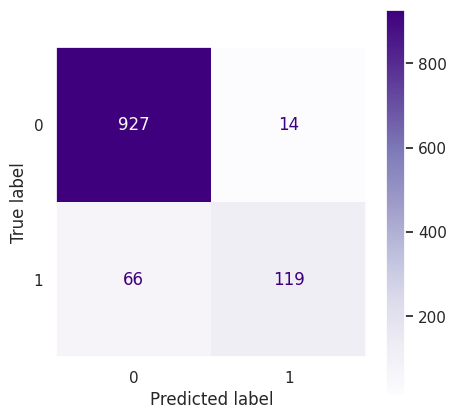

In [ ]:
k = 2
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train, y_train)
evaluate_and_display_metrics(knn, X_train, X_test, y_train, y_test)

KNN performs pretty well with a testing balanced accuracy > 80% but it might be slightly overfitting since there is a gap between training and test balanced accuracy.

## Logistic regession

  Dataset  Accuracy  Balanced accuracy  Precision
0   Train  0.874556           0.678786   0.756477
1    Test  0.879218           0.678031   0.769231


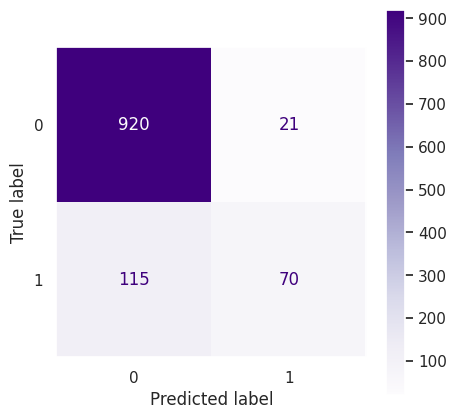

In [ ]:
logreg = LogisticRegression(random_state = 0)
logreg.fit(X_train, y_train)
evaluate_and_display_metrics(logreg, X_train, X_test, y_train, y_test)

Logistic regression performs not as well as the others as indicated by its low balanced accuracy *(67.8%)* and precision score *(76.92%)*.

## Decision tree

  Dataset  Accuracy  Balanced accuracy  Precision
0   Train  0.986012           0.964454   0.984765
1    Test  0.953819           0.905058   0.880000


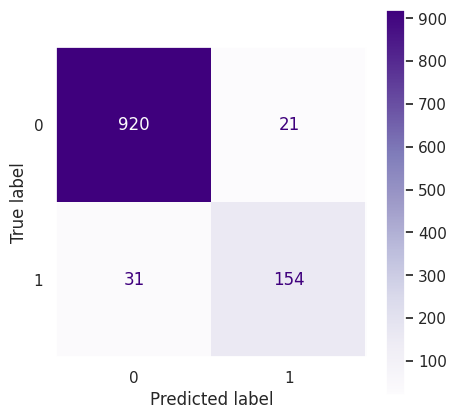

In [ ]:
dec_clf = DecisionTreeClassifier()
dec_clf.fit(X_train, y_train)
evaluate_and_display_metrics(dec_clf, X_train, X_test, y_train, y_test)

Decision tree performs very well with high balanced accuracy *(90.51%)* and precision score *(88%)* on test set. There is no significant overfitting or underfitting issues.



## Random forest

  Dataset  Accuracy  Balanced accuracy  Precision
0   Train  0.984680           0.972520   0.955381
1    Test  0.953819           0.902887   0.884393


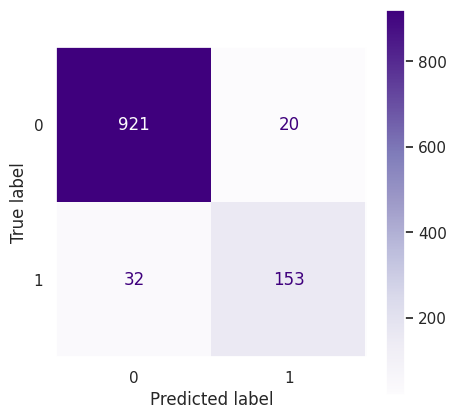

In [ ]:
rf_clf = RandomForestClassifier(n_estimators = 10, random_state = 0)
rf_clf.fit(X_train, y_train)
evaluate_and_display_metrics(rf_clf, X_train, X_test, y_train, y_test)

Random forest also performs well without significant overfitting or underfitting issues. However, its balanced accuracy *(90.29%)* is slightly lower than of decision tree *(90.51%)*.

## Tune hyperparameters

After evaluating models -> Decide to proceed with hyperparameter tuning for the decision tree model due to its high balanced accuracy.

In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
param_grid = {'criterion': ['gini', 'entrp'],
              'max_depth': [3, 5, 9, 15, 17, 19, 21, 23],
              'min_samples_split': [2, 4, 6]
              }
grid = GridSearchCV(dec_clf, param_grid, cv = kf)
grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _vali

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entrp'],
                         'max_depth': [3, 5, 9, 15, 17, 19, 21, 23],
                         'min_samples_split': [2, 4, 6]})

In [ ]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 21, 'min_samples_split': 2}

In [ ]:
grid.best_score_

0.9320572203724258

  Dataset  Accuracy  Balanced accuracy  Precision
0   Train  0.986012           0.964454   0.984765
1    Test  0.955595           0.912635   0.877095


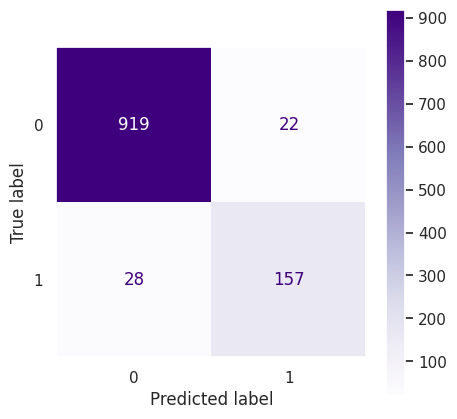

In [ ]:
# Rebuild decision tree model with best estimator
best_dec_clf = grid.best_estimator_
best_dec_clf.fit(X_train, y_train)
evaluate_and_display_metrics(best_dec_clf, X_train, X_test, y_train, y_test)

Decision tree model after hyperparameter tuning improves performance with higher testing accuracy and balanced accuracy.